# Part 3, Topic 3: DPA on Firmware Implementation of AES (HARDWARE)

---
**THIS IS NOT THE COMPLETE TUTORIAL - see file with `(MAIN)` in the name.**

---

First you'll need to select which hardware setup you have. You'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`. `SCOPETYPE` can either be `'OPENADC'` for the CWLite/CW1200 or `'CWNANO'` for the CWNano. `PLATFORM` is the target device, with `'CWLITEARM'`/`'CW308_STM32F3'` being the best supported option, followed by `'CWLITEXMEGA'`/`'CW308_XMEGA'`, then by `'CWNANO'`. `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms. An alternative for `'CWLITEXMEGA'` targets is `'AVRCRYPTOLIB'`. For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

The following code will build the firmware for the target.

In [2]:
#import chipwhisperer as cw
#scope = cw.scope()

%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWNANO.hex
rm -f -- simpleserial-aes-CWNANO.eep
rm -f -- simpleserial-aes-CWNANO.cof
rm -f -- simpleserial-aes-CWNANO.elf
rm -f -- simpleserial-aes-CWNANO.map
rm -f -- simpleserial-aes-CWNANO.sym
rm -f -- simpleserial-aes-CWNANO.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i aes.i aes-independant.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:9-2019-q4-0ubuntu1) 9.2.1 20191025 (release) [ARM/arm-9-branch revision 277599]
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the sou

Size after:
   text	   data	    bss	    dec	    hex	filename
   5636	    540	   1628	   7804	   1e7c	simpleserial-aes-CWNANO.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CWNANO Built-in Target (STM32F030) with:
+ CRYPTO_TARGET = TINYAES128C
+ CRYPTO_OPTIONS = AES128C
+--------------------------------------------------------


In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))
print(target.read())

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6175 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6175 bytes
heXXX



For this tutorial, we'll need to capture around 2500 traces:

In [5]:
import tqdm 
#import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []
textout_array = []

key, text = ktp.next()

target.set_key(key)

scope.adc.samples = 3000

print(scope.adc.samples)

N = 1000
for i in range(N):
    print("+")
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    print("text", text)
    print("response", response)
    
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    textout_array.append(response)
    
    key, text = ktp.next() 

3000
+
text CWbytearray(b'47 8d dd ee dd 0e bc 8c 8e 32 8c ed cc 7a 99 62')
response CWbytearray(b'70 d4 5c 10 d0 da ee db f8 5b 8d 7e 00 73 87 9f')
+
text CWbytearray(b'03 b9 14 2c 8c 57 f9 90 8b 10 a1 60 a9 2b 20 fd')
response CWbytearray(b'74 e4 ea 5c 83 74 27 90 d1 98 7a ab e2 6a 49 9a')
+
text CWbytearray(b'5e 94 1b fb ce 1e aa 0e 4e 27 6a cf a3 6a ae e0')
response CWbytearray(b'98 39 eb 5b 59 4b 84 ff a4 d2 3d eb 16 39 25 66')
+
text CWbytearray(b'52 77 69 ba e0 05 f2 1b ce 3a 5c ca 44 61 ab df')
response CWbytearray(b'7a cf e0 fa 95 b7 a0 d0 a6 c0 9f 0a 3b 7d 2d ce')
+
text CWbytearray(b'38 b0 de 55 35 e1 40 04 19 7d 69 26 a3 ed b4 d7')
response CWbytearray(b'e8 f0 76 e4 d3 e2 8a 37 10 1e e0 91 44 87 60 38')
+
text CWbytearray(b'1f 8c da ca 4f aa 1d 6f ce 16 35 9b 2f 35 76 f7')
response CWbytearray(b'c6 ed b7 5c 15 c2 34 d7 88 18 c0 31 13 af bd 62')
+
text CWbytearray(b'61 68 32 3c 20 e5 5e aa 71 bf 80 3f 65 78 ac 32')
response CWbytearray(b'5c 82 7d 30 6b 60 47 8d 59 35 ce 53 6

text CWbytearray(b'47 5f 6b 2c 75 c2 a1 3e a5 d7 ee 21 5a ed 30 09')
response CWbytearray(b'a9 42 e5 c2 bf a0 ea 4b 18 ba 72 4c 0d 88 99 30')
+
text CWbytearray(b'70 b3 d8 00 bb 63 58 7a bd d0 5c cd 33 7c 58 19')
response CWbytearray(b'9a 8d d9 2e 5c aa dd 67 11 b7 a7 41 1a 40 5a e2')
+
text CWbytearray(b'f6 95 f5 df 59 d9 3e 6a a1 76 1d ec ce 4c 9f bf')
response CWbytearray(b'db 8d 3e 1d ff d1 e8 da db 55 be cd a9 17 3e 44')
+
text CWbytearray(b'f7 5b 89 09 89 43 13 a2 eb 40 55 5a f3 41 d1 25')
response CWbytearray(b'47 92 60 16 b1 44 e7 da 50 5d 0f 76 4b f5 66 21')
+
text CWbytearray(b'1c 37 10 2a fc e3 92 96 a7 c3 86 b7 88 81 29 6e')
response CWbytearray(b'55 7b 74 33 67 42 0e f0 fe 4b 9e 3f e0 c2 ec 5c')
+
text CWbytearray(b'2c 4a eb 76 75 e3 2a 1a cb 51 8d 2a 1c 20 d5 9f')
response CWbytearray(b'07 b5 63 f8 3f 9f 2f 41 fc 29 72 fc 2b fb 51 53')
+
text CWbytearray(b'74 34 a0 0f 83 2b 7b ae d1 27 8a 2e 46 d7 6c 44')
response CWbytearray(b'3a 49 e7 83 29 41 76 9d 1d 26 49 10 09 e6 32

text CWbytearray(b'0c 48 68 53 db 3f 6a 1e e6 2f 5a 08 75 44 09 58')
response CWbytearray(b'bb b2 be a6 21 09 92 5a d4 75 cf 2f 2e 08 89 88')
+
text CWbytearray(b'c1 66 99 af b5 ad d1 51 e5 c5 82 14 9d e6 59 66')
response CWbytearray(b'2b f1 01 be b9 c2 bd a9 f7 46 33 3b e2 23 fa 0b')
+
text CWbytearray(b'48 2b 77 27 0d f1 58 99 95 d8 6c 8a a2 61 b8 ab')
response CWbytearray(b'a6 8e 71 6a 7e 0a 70 2b c9 07 44 df b3 2a 42 82')
+
text CWbytearray(b'3f 54 5d e6 2c 3b 4b 38 7c 2b 75 c8 c5 9c 65 31')
response CWbytearray(b'a3 d4 98 87 ec 02 e7 44 c6 1e ad d3 3e 5f 1f 7d')
+
text CWbytearray(b'd0 96 e6 06 3d d0 92 09 b1 4b 73 18 f4 f2 9b ac')
response CWbytearray(b'24 1b 43 a9 36 3f 47 2a 2f 60 96 b9 10 9e 53 00')
+
text CWbytearray(b'48 85 a6 d9 5e f7 05 04 9b af 37 be ba 5f c0 f1')
response CWbytearray(b'72 89 be bd c4 c8 54 5f c3 75 cf ca aa df c5 b6')
+
text CWbytearray(b'23 73 fc 20 4f 57 96 f3 9a 19 ff 2a c3 84 09 d2')
response CWbytearray(b'35 e5 79 80 d5 28 41 01 be f7 cb 76 3b 5d 05

text CWbytearray(b'07 60 70 5a a3 e0 ec 7e 37 60 99 63 ca de c0 9d')
response CWbytearray(b'fe 34 1b f5 6c 24 86 ab e8 fa be eb 3d 80 90 e0')
+
text CWbytearray(b'80 56 be 30 8a b0 0f e2 dc 54 4b 22 47 d3 94 c5')
response CWbytearray(b'71 81 fb ed 70 4a 80 10 dd 17 76 d2 20 33 05 24')
+
text CWbytearray(b'45 1e 5b 71 e8 a3 64 b9 87 f7 27 f8 15 6f 84 11')
response CWbytearray(b'c3 5f 20 52 03 d0 6c d5 eb be a0 d2 96 cc 50 3a')
+
text CWbytearray(b'de b0 67 51 ca a7 62 a3 df ca 9f f3 e6 de 6a 38')
response CWbytearray(b'f6 3b db 81 37 5e 5c cf 8c 1d 87 f6 58 1b 18 f7')
+
text CWbytearray(b'15 93 50 f5 44 9e 24 51 67 cc e4 f4 cb b8 ba db')
response CWbytearray(b'29 a2 77 af b8 7e 8e 0b 23 d6 f0 a7 d2 03 2c b0')
+
text CWbytearray(b'd1 84 f3 0b f3 d3 fa 6b 3d 07 9b e6 ff 63 55 b4')
response CWbytearray(b'e8 4f 3a 3f 60 05 5d 6d d7 08 55 b8 55 29 26 30')
+
text CWbytearray(b'a0 b0 7d 65 6b 93 ff 07 9c 51 9f 1b dc 89 68 6a')
response CWbytearray(b'78 cc d0 90 fe a7 74 c5 be 7c b3 21 b9 e3 4d

text CWbytearray(b'f3 76 2c bf fc 04 c8 4f 61 2e c3 2e 64 18 83 9f')
response CWbytearray(b'45 55 f3 b6 89 4e ad 63 a1 f1 65 7b cf aa c1 18')
+
text CWbytearray(b'67 04 d5 f0 3f b0 7e 46 1b 82 03 3e 3d fa 48 ed')
response CWbytearray(b'f0 75 ff b9 ab a5 44 b5 0b 4f 3e 04 73 0c 3e a3')
+
text CWbytearray(b'2b 77 18 28 44 76 69 51 85 9d d1 13 a8 4b 5f 86')
response CWbytearray(b'd5 ac ed 74 e6 ba c8 56 97 88 f1 10 1c 89 85 66')
+
text CWbytearray(b'8b 3d 5a 30 77 14 39 0c 64 1a 0d f7 89 e4 87 68')
response CWbytearray(b'de 11 74 11 86 07 7e 8b 9f 7a d0 51 2e 4d 28 79')
+
text CWbytearray(b'b5 67 9f 23 fa 09 8c b2 81 5e 34 a6 63 49 fa 7e')
response CWbytearray(b'80 16 a0 0c 85 b5 2e 1f 72 bc c3 c1 8a 21 1f 2c')
+
text CWbytearray(b'91 6e 97 77 4e 65 b1 08 ef 7c fc d1 e9 c2 c8 54')
response CWbytearray(b'5a 9a 90 3b 5f 04 ca c6 db 23 54 2b 48 9c a4 5c')
+
text CWbytearray(b'96 09 d7 9e 62 dd 2b 3d 74 4b 17 8f af ea 3f 5f')
response CWbytearray(b'bb 0b b9 75 79 27 2a 79 ef ad f9 af 69 50 33

text CWbytearray(b'7e b4 79 fc 5e f4 9a f9 21 ac 4d ef 76 18 9f 96')
response CWbytearray(b'40 45 69 5d 6c ca 98 d4 f4 15 01 50 0f b9 e5 f7')
+
text CWbytearray(b'53 0c 0b 72 d3 f3 99 b8 bc d2 c4 8a 7c ac ac 94')
response CWbytearray(b'50 dd 33 5b 0b 8c 4c ec ea c0 a3 08 60 a2 77 82')
+
text CWbytearray(b'0e 32 c9 34 a7 9e cb 0c 8e a0 63 2e 9b 57 1f e0')
response CWbytearray(b'11 81 07 a9 02 58 10 74 1f b0 9e 6e ef 5a c7 8b')
+
text CWbytearray(b'e2 27 40 c1 a1 89 db 24 e5 91 ec 8c 96 98 48 ff')
response CWbytearray(b'7b 21 17 45 6c b9 8d f4 f1 3d a0 07 25 69 17 b0')
+
text CWbytearray(b'67 8f 70 16 f2 1a 85 ef 6e 4d 39 6e 92 eb 49 ce')
response CWbytearray(b'b8 2e ce 97 10 eb fe 75 16 de 2c 1f ce 2c c1 e9')
+
text CWbytearray(b'70 49 c7 bb b3 8e 43 ba 5c 07 f5 64 e8 d4 07 12')
response CWbytearray(b'f5 e0 78 aa ca 0a 25 24 b6 40 2f 08 c0 d0 83 1a')
+
text CWbytearray(b'16 7b 82 a6 7b ae 07 0f 23 0b 75 77 22 aa 36 46')
response CWbytearray(b'6f f9 af 0a 19 c3 df 93 02 75 77 69 3d e2 68

text CWbytearray(b'e2 3d 07 c9 5d 06 72 21 e8 06 8c 54 93 17 d4 00')
response CWbytearray(b'72 f5 1d 65 00 0d 97 61 b9 4e 48 5d 1f 83 89 7e')
+
text CWbytearray(b'29 c6 42 c7 7e b4 8d 5e 80 b4 f7 d9 23 dc 6e 69')
response CWbytearray(b'd3 f7 d6 8e b1 dc de 76 0d 80 4f a8 97 3d ab 8d')
+
text CWbytearray(b'01 cc 47 09 9b 77 cc 93 39 51 3f f0 b3 48 67 ec')
response CWbytearray(b'9c 54 0a 22 92 34 bf 92 9a 97 b6 14 cb e4 1a 5a')
+
text CWbytearray(b'9c 70 1a 11 01 38 43 1b b8 5f a4 39 24 8f 01 ba')
response CWbytearray(b'd8 8e 83 45 c8 89 19 ad 8c 6d ae 8a 2b cb 02 9c')
+
text CWbytearray(b'88 87 ad 9a 04 4e 34 b9 f8 a9 1b 67 90 ba 29 79')
response CWbytearray(b'd5 0e db 75 bd c5 6a 5f 43 51 46 22 78 32 a2 2c')
+
text CWbytearray(b'59 c2 0e e3 71 9d 14 6c 57 d4 3e 12 72 d9 ba 9e')
response CWbytearray(b'c2 05 85 0c 6f c8 cb 62 82 04 c5 e3 1d 0d 43 df')
+
text CWbytearray(b'da 04 e9 54 e3 f8 6c 48 cf db dc 6c 81 5a 10 8f')
response CWbytearray(b'2f 79 cf 2b c1 6f a1 d9 43 3e 6a 2f 13 f3 11

text CWbytearray(b'd6 b5 2f de cd b6 74 67 3a 1b 43 6e e6 a0 b3 12')
response CWbytearray(b'aa a8 b8 2a 3d 62 05 6d 9c 66 12 1b f4 88 85 eb')
+
text CWbytearray(b'f4 80 f5 99 75 7c d8 b0 a8 d4 3a de 1a 2d be 73')
response CWbytearray(b'56 a7 6b d7 b0 6b 70 c4 0b 2f 6b 44 60 5f 4d e7')
+
text CWbytearray(b'25 89 32 7c ac c0 45 8a 8c 14 48 ae 4b 4c e1 28')
response CWbytearray(b'c9 a3 14 fe 54 27 ef af c0 1a 8e e6 f4 89 a0 ca')
+
text CWbytearray(b'3c 07 e5 8d c6 44 77 33 a0 3b be 74 5f 54 5e 10')
response CWbytearray(b'88 a4 a0 04 58 1e 86 33 a8 12 ea 17 88 32 2a cf')
+
text CWbytearray(b'7a 8c dc f0 bc 7d 7e 92 5a ae 96 bc 8a 82 03 b7')
response CWbytearray(b'08 b7 a4 c8 0a bd 1e bd c2 31 98 17 b3 2c 28 b8')
+
text CWbytearray(b'd4 40 d8 32 a4 63 4a ab e2 a0 96 b6 a7 04 a1 c5')
response CWbytearray(b'c7 cd 75 29 52 50 bc 4e a6 40 e3 8d 0b 93 21 d7')
+
text CWbytearray(b'd6 fd aa ce ab 6e 6f 91 f6 88 6f 3f 8b f9 3d 16')
response CWbytearray(b'41 94 18 49 f5 fb f1 47 17 48 aa ad d9 99 c1

text CWbytearray(b'f4 5f 2c 44 3c d9 0b ac fb 39 1d fe d8 7e 33 31')
response CWbytearray(b'dd f6 32 3c 7b c7 4b cd ec af ed 72 06 70 33 cd')
+
text CWbytearray(b'27 57 28 5c a4 e8 86 a7 9a 8e ca 4f 23 05 47 bb')
response CWbytearray(b'74 e9 8b 78 5e 88 ca f0 83 33 0b 71 5b 49 59 27')
+
text CWbytearray(b'b6 36 cf ff 89 21 b4 27 80 f6 71 77 03 0c 66 3a')
response CWbytearray(b'eb a9 02 7d d4 0d 16 1c 37 4b ce 6e b8 f8 ff 05')
+
text CWbytearray(b'9e 4d da b2 db 53 07 85 01 f6 44 c6 10 01 70 91')
response CWbytearray(b'dc e3 b6 b5 7d b5 12 c9 a5 22 45 27 79 92 b9 8b')
+
text CWbytearray(b'5f 32 3b 7a 6f 8a fb 17 ec 8d d8 6d 12 f9 60 b3')
response CWbytearray(b'b0 b1 81 68 6d cb 5f a7 18 63 31 d5 4c 75 94 61')
+
text CWbytearray(b'88 28 f4 35 62 19 4c 53 67 50 4f 55 ca 30 ba 2c')
response CWbytearray(b'ef 91 51 ed 9e 28 7d 41 94 4c ab 25 08 48 e0 cb')
+
text CWbytearray(b'70 55 9b 83 79 5e 47 f9 c2 76 c9 4b 26 ec 5e c0')
response CWbytearray(b'08 0a bd 68 95 40 aa be c0 0c 4f 92 b6 4b ae

text CWbytearray(b'f8 41 e4 67 94 6b ca dc d8 3b 76 e3 f5 9d a0 a3')
response CWbytearray(b'b3 46 47 d4 7f a3 51 e1 dc 22 cb b4 ab 43 11 6f')
+
text CWbytearray(b'30 ef 7b 96 80 d7 c6 cc 85 81 69 1a 03 a7 25 68')
response CWbytearray(b'f8 ce de c0 da 7a af c9 aa 1a 01 1a 8c 32 6a 3f')
+
text CWbytearray(b'df 9f 38 4c 23 67 08 e0 8e 87 6f 3e a3 fb d6 6f')
response CWbytearray(b'2a 07 d1 80 4c dc f3 51 b9 8f bb a2 70 a7 ca 3c')
+
text CWbytearray(b'c5 c5 e7 25 51 d8 ba ad 30 7c af 1c 9f d0 70 f6')
response CWbytearray(b'ba ab b2 f3 a8 26 65 78 0c c1 45 2c ec 20 89 bc')
+
text CWbytearray(b'4e c6 06 7b 56 eb 47 83 96 11 56 eb 3a 42 87 92')
response CWbytearray(b'65 29 31 a3 0b 96 05 8d fd 98 97 67 f3 94 f9 24')
+
text CWbytearray(b'27 e0 fc 8e a5 40 38 b8 c4 3a 8d 02 62 65 cf 10')
response CWbytearray(b'7f bd e4 e1 23 32 37 e0 87 f8 e3 95 ee 71 27 9b')
+
text CWbytearray(b'30 46 0b f5 1a e0 9d 96 20 49 68 26 e5 60 a6 6f')
response CWbytearray(b'bc 40 59 49 31 cd cb c0 38 b0 c3 d7 54 b1 c9

text CWbytearray(b'ac 4a 40 72 64 0b 56 80 e6 ab b1 4d c7 19 87 c0')
response CWbytearray(b'fb 26 7d 82 aa 7e 9c 3d 47 c5 4c 0a b3 3f cf 1f')
+
text CWbytearray(b'd6 90 81 72 50 a1 e8 cf 83 e2 28 da 5b b4 6a eb')
response CWbytearray(b'8c b7 89 87 23 8c 80 8f 5e ff dd ef 36 d0 04 72')
+
text CWbytearray(b'4f 6b 87 f1 7a b5 c6 92 70 38 94 a5 4c e8 1f 24')
response CWbytearray(b'f6 f5 27 6d d6 34 cd 5f 9c 9e 45 15 07 db d2 17')
+
text CWbytearray(b'07 41 58 c7 95 43 d9 09 c8 53 56 b1 d3 25 63 bf')
response CWbytearray(b'df 34 34 a1 e8 4a ef ee 42 af 92 4e eb 05 d5 97')
+
text CWbytearray(b'72 61 05 3d 49 0a 55 22 0c 03 7a 41 35 fa d2 92')
response CWbytearray(b'6c 08 11 ff b7 fe 6f fc 4e e2 ca 61 d8 e9 23 c2')
+
text CWbytearray(b'1d 88 8b b0 23 c0 5d 62 03 24 5e de 2d f8 f9 68')
response CWbytearray(b'b1 6f 4f 01 38 4a 29 e9 28 7d 51 aa 38 72 7f bf')
+
text CWbytearray(b'1c 8d 39 6e b8 cb 18 ec 0f 88 6b 8c a1 bd 37 2b')
response CWbytearray(b'33 6d 40 aa 6c d6 74 d3 55 cc ed 95 7a d5 79

text CWbytearray(b'e9 71 3d ec 8a 41 0d e0 aa 7c 9f a5 4c 64 d7 44')
response CWbytearray(b'43 4e fe 3f dd 85 3f 2b 3e 21 23 35 d6 0a 59 c0')
+
text CWbytearray(b'cd 4f 3b 13 16 c6 a4 fa 52 c3 c2 63 04 d4 1e d9')
response CWbytearray(b'57 5d b0 2a d6 66 ce 4f 55 19 fb 0b 6f 77 1c 79')
+
text CWbytearray(b'71 e0 1f d2 cf 6e e4 3a ea 5b b0 54 a8 84 04 d0')
response CWbytearray(b'c9 4a 63 d6 7e 8a 19 ea 11 eb 67 13 5a dc d8 2a')
+
text CWbytearray(b'd7 2c 43 21 7c 2f 49 30 9f fe 18 76 e3 cf dc db')
response CWbytearray(b'a6 38 e6 77 57 4b 40 da 3d 12 ae fc b8 bc 36 2a')
+
text CWbytearray(b'14 4b dc 75 5c 17 5b 63 73 c8 57 62 57 00 f4 6e')
response CWbytearray(b'e1 90 4c b8 1b b7 02 15 c2 14 7f c5 8b 92 1c d4')
+
text CWbytearray(b'19 6e 02 d9 d0 50 02 5c 6c a2 fb 04 7c 93 a4 5a')
response CWbytearray(b'8d d1 41 be d2 6f ac 3b 11 be c7 b4 dc ea 61 ac')
+
text CWbytearray(b'c7 79 cb 22 da fd 59 24 1e fd 59 03 fe 7a 4f 15')
response CWbytearray(b'15 f8 fb c9 c1 28 a5 99 4c b2 ed f1 d3 97 48

text CWbytearray(b'9c 29 2a 7b fc a2 70 a3 98 7a 80 02 b1 da d4 96')
response CWbytearray(b'8f 36 93 71 70 5a 5f 69 23 62 ff 1f d7 d0 b1 02')
+
text CWbytearray(b'5c f4 2c 70 b5 d8 14 dc 3c 11 8c fc a0 e5 2c de')
response CWbytearray(b'42 f9 7e 9f 17 15 9a 6d 71 35 25 e9 36 14 0f 22')
+
text CWbytearray(b'c9 41 da d8 7a 07 1b 94 a5 fc 3d f6 f8 4d a6 99')
response CWbytearray(b'04 a5 a5 84 49 65 3c ef 9f a6 c0 a9 07 f1 54 42')
+
text CWbytearray(b'22 cb 2d 36 47 83 e2 2e 93 3b 34 be 69 fa b2 61')
response CWbytearray(b'86 7a f8 da 6b 95 d5 fe 67 ed 9f e1 d1 6d f6 f7')
+
text CWbytearray(b'34 8b 87 84 68 37 51 9c 41 1e 27 33 10 56 db a2')
response CWbytearray(b'8f f7 a2 92 02 a1 87 cc 02 3b 29 8d 1b fb f6 37')
+
text CWbytearray(b'9b ca d6 6a c4 ad ad 57 6a 10 6a 8e dc 05 da b3')
response CWbytearray(b'eb d7 6e d9 89 bd 0f de 86 f4 55 42 b8 c9 83 1b')
+
text CWbytearray(b'f8 0b 2c 8d 67 fe 14 b0 f1 92 e7 ca ba 1b f6 19')
response CWbytearray(b'91 ed 69 20 60 e6 cd b3 29 c6 74 23 eb 11 96

text CWbytearray(b'81 d3 ed 1b be cd 12 83 21 04 50 7c c2 31 86 4c')
response CWbytearray(b'a9 63 30 73 cd ea 32 cb 5f 6c ce b8 df be ee 3c')
+
text CWbytearray(b'c2 58 a5 5e 93 e9 f4 da 60 cb 4c 22 4d 88 64 b5')
response CWbytearray(b'3f ad 1e 59 fd be 55 48 34 03 ff a7 a6 91 23 0b')
+
text CWbytearray(b'4c 9b 1d 4d 63 48 42 87 53 45 5b f9 c7 ff eb 10')
response CWbytearray(b'79 2b 63 ba d3 9b 62 e5 b8 93 7e 15 7d 2e 02 8f')
+
text CWbytearray(b'35 42 69 48 57 5e be b5 4a 13 97 e2 ac 45 2e d3')
response CWbytearray(b'97 99 82 bb 52 a2 11 35 9d 5f ff 57 39 b9 1f 8b')
+
text CWbytearray(b'97 00 30 df a5 91 5f e4 80 48 72 4b b2 1e fe ef')
response CWbytearray(b'cc 30 b2 9a 9f b3 35 4f a5 e0 d1 34 e9 00 36 fc')
+
text CWbytearray(b'3c 4e 42 b0 53 cd b0 19 e7 7a fc b1 94 a1 07 42')
response CWbytearray(b'f8 57 21 a1 cc e7 63 79 1b 83 94 29 fd 1e 13 0f')
+
text CWbytearray(b'05 de b7 ff 48 dd a9 37 da 41 db 41 d3 d3 12 36')
response CWbytearray(b'e6 4c 85 45 44 42 18 bf 8e 07 0e 33 79 91 92

text CWbytearray(b'24 38 1d ae b1 41 e6 ff 2b d8 3a ad e0 92 b7 8b')
response CWbytearray(b'2a 94 22 84 ee 8e e0 ae 1a 2b 10 7d 20 a7 28 0f')
+
text CWbytearray(b'41 33 f1 26 e8 35 a1 eb 42 9f 52 7e 2a c1 66 d4')
response CWbytearray(b'8f 35 6c 30 98 1d 1b 25 eb 6c a3 b8 46 33 49 fa')
+
text CWbytearray(b'cd 8f e9 d0 b6 5f 0a 9b 2f 5b b1 4d ad 16 62 57')
response CWbytearray(b'f4 1d 54 a7 44 73 17 c1 28 56 72 8d 69 3f bb 5b')
+
text CWbytearray(b'f7 0e 23 8a ac e7 27 83 70 a1 fb 30 bb 2f ea f0')
response CWbytearray(b'a5 7c c7 16 9e a9 2c 22 d2 da 16 4d 44 db d9 5a')
+
text CWbytearray(b'64 e5 be 2f bc 68 bb dd 4d f0 20 50 b8 8f 4c 97')
response CWbytearray(b'70 53 93 2d 79 20 52 2f e0 19 93 c8 a7 ec 13 5d')
+
text CWbytearray(b'9d 47 7d 47 17 e0 14 c2 e9 ff 2e 37 da b1 75 56')
response CWbytearray(b'8a 6b df ac 30 ad 41 00 1c be 96 6f 08 4c a8 6c')
+
text CWbytearray(b'83 13 8d e5 de 05 82 9c 63 77 7f b4 98 9e f8 7b')
response CWbytearray(b'48 01 b8 aa 00 e2 89 80 dc aa 9e fa 95 6f da

text CWbytearray(b'a8 52 74 ed 22 0b 0b 66 5b d7 76 dd fc 9e 03 28')
response CWbytearray(b'37 74 e3 7f 51 99 0a 5c 90 07 4c 46 95 29 cc 22')
+
text CWbytearray(b'd8 dc 61 78 7a d8 6e 97 4c a9 e1 5f 56 b6 07 a3')
response CWbytearray(b'1c 36 d7 ab fe ec 86 c5 d5 cf e0 5c d1 4c e6 fe')
+
text CWbytearray(b'12 7a 60 09 d6 2b 9e 76 94 61 6b 7d c9 44 ab 0f')
response CWbytearray(b'6b fc 86 81 81 6e a3 8f 2f 7a bd 0c 84 0f e7 e1')
+
text CWbytearray(b'da d0 96 ae 2e 69 67 3a 5c f9 46 a2 5a 83 00 df')
response CWbytearray(b'48 bd 23 60 6a e1 6d 26 5b bb 0c d5 a8 a9 27 75')
+
text CWbytearray(b'f8 f5 5a 3f 30 a6 01 a0 4e 9d 9f ae 24 0a cf ee')
response CWbytearray(b'33 09 26 64 cf e8 cf bc 51 c9 25 d5 65 b5 af 8a')
+
text CWbytearray(b'3b 39 ee 9f 02 ed f5 3e 84 50 8f 3a 05 e5 df ed')
response CWbytearray(b'ad 62 96 98 62 02 f4 09 b2 e8 f7 e9 22 3b 79 e7')
+
text CWbytearray(b'13 24 b0 59 2a ef c2 ec e2 ec a8 7f 35 2a 1b ec')
response CWbytearray(b'13 79 73 38 85 60 80 9e 58 06 56 6d 42 37 10

text CWbytearray(b'5e 01 b1 6c ee 23 b0 b1 21 d5 6b 76 d0 58 e3 c8')
response CWbytearray(b'da 4e 98 fc df e9 d3 e7 9e 31 a6 ec 87 20 19 a2')
+
text CWbytearray(b'a5 0e f3 ab d9 d0 0e e1 67 fb a5 2d 9d 7d f4 f1')
response CWbytearray(b'29 88 d6 e2 47 e0 b9 e8 a3 a0 e8 8b f9 c5 bd 5a')
+
text CWbytearray(b'39 19 41 fb d2 72 60 98 e8 d9 9c 3a d8 88 4d cb')
response CWbytearray(b'31 c9 d9 b9 f6 fb 5f ce 87 60 f6 ca d1 a5 d2 a0')
+
text CWbytearray(b'98 e4 3a 7c 19 5b 26 b6 f2 bb ed 6f d3 d6 8c c2')
response CWbytearray(b'83 78 0f 79 34 e1 1b 92 13 fd 60 38 59 02 4c 69')
+
text CWbytearray(b'08 6d d5 42 e9 b6 5e df 98 82 f5 4f a1 7f 1d f0')
response CWbytearray(b'5d 97 0b 9a 0c 55 b0 e7 6d 11 eb 26 66 3e 74 f2')
+
text CWbytearray(b'7d 7e 95 88 15 6f 83 30 47 b9 2e 7c d1 be e5 95')
response CWbytearray(b'1f be 40 7b 29 ab 4c 37 37 bd b8 b7 7f 1c be b8')
+
text CWbytearray(b'b5 c3 ca d9 70 08 ed b7 20 19 18 81 ac b2 d7 05')
response CWbytearray(b'3e 62 06 30 fd 60 f0 20 a0 54 f2 77 3a 2e d2

<IPython.core.display.Javascript object>


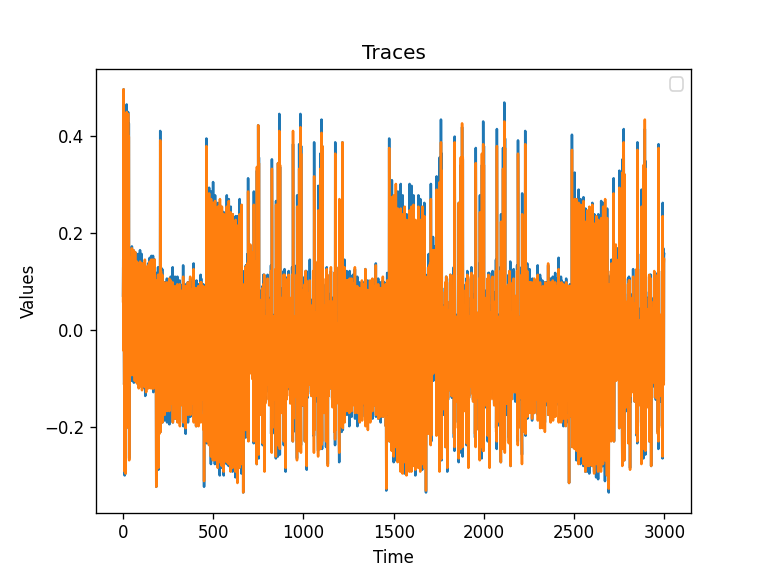

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


In [6]:
%matplotlib notebook
import matplotlib.pylab as plt

#print(trace_array[0])
#print(trace_array[1])
plt.figure()
plt.plot(trace_array[1])
plt.plot(trace_array[999])
#plt.plot(trace_array[2])
#plt.plot(trace_array[4])
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Traces")
plt.legend()
plt.show()
print(key)

In [7]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]
# ###################
# END SOLUTION
# ###################
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)
# ###################
# END SOLUTION
# ###################

✔️ OK to continue!


In [10]:
maxcpa = [0] * 256

# we don't need to redo the mean and std dev calculations
# for each key guess
t_bar = mean(trace_array)
o_t = std_dev(trace_array, t_bar)

for kguess in range(0, 256):
    hws = np.array([[HW[aes_internal(textin[0],kguess)] for textin in textin_array]]).transpose()

    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add your code here, and delete this.")

    # ###################
    # START SOLUTION
    # ###################
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = correlation/(o_t*o_hws)
    maxcpa[kguess] = max(abs(cpaoutput))


guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)
# ###################
# END SOLUTION
# ###################
print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)

/tmp/ipykernel_5779/79474529.py:22: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput = correlation/(o_t*o_hws)


Key guess:  0x2b
Correlation:  0.8049572057190527


In [13]:
t_bar = np.sum(trace_array, axis=0)/len(trace_array)
o_t = np.sqrt(np.sum((trace_array - t_bar)**2, axis=0))

cparefs = [0] * 16 #put your key byte guess correlations here
bestguess = [0] * 16 #put your key byte guesses here

for bnum in range(0, 16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
    # ###################
    # Add your code here
    # ###################
    #raise NotImplementedError("Add your code here, and delete this.")

    # ###################
    # START SOLUTION
    # ###################
        hws = np.array([[HW[aes_internal(textin[bnum],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)
    # ###################
    # END SOLUTION
    # ###################

print("Best Key Guess: ", end="")
for b in bestguess: print("%02x " % b, end="")
print("\n", cparefs)

/tmp/ipykernel_5779/3211073133.py:22: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput = correlation/(o_t*o_hws)


Best Key Guess: 2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c 
 [0.8049572057190527, 0.7966186541131223, 0.7974758467345887, 0.8154904758046223, 0.7960325440110866, 0.829201039187441, 0.7867652124291568, 0.8110236389536924, 0.7796233270605596, 0.8414170146731154, 0.7953311965655939, 0.842966527059313, 0.8221634195895575, 0.8171988299173816, 0.7918544047464274, 0.8125049523726972]


In [14]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add Your Code Here")

# ###################
# START SOLUTION
# ##########guessed_byte#########
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):

    one_list = []
    zero_list = []

    for trace_index in range(numtraces):

        #Get a hypothetical leakage list - use aes_internal(guess, input_byte)
        hypothetical_leakage = ...

        #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
        if hypothetical_leakage & 0x01:
            ...
        else:
            ...
    one_avg = np.asarray ...
    zero_avg = np.asarray ...
    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))

    print("Guessing %02x: %f"%(guess, mean_diffs[guess]))

maxdiff = max(mean_diffs)
indmax = np.argmax(mean_diffs)
#print(mean_diffs)

print("Best Key Guess: ", end="")
print("%02x, difference: %f" % (indmax, maxdiff), end="")
print("\n")

# ###################
# END SOLUTION
# ###################

Guessing 00: 0.003994
Guessing 01: 0.003213
Guessing 02: 0.003100
Guessing 03: 0.002897
Guessing 04: 0.002550
Guessing 05: 0.003931
Guessing 06: 0.003092
Guessing 07: 0.002942
Guessing 08: 0.004031
Guessing 09: 0.006746
Guessing 0a: 0.008915
Guessing 0b: 0.004432
Guessing 0c: 0.004136
Guessing 0d: 0.003226
Guessing 0e: 0.003512
Guessing 0f: 0.004057
Guessing 10: 0.004544
Guessing 11: 0.003490
Guessing 12: 0.006147
Guessing 13: 0.005701
Guessing 14: 0.003686
Guessing 15: 0.005919
Guessing 16: 0.005236
Guessing 17: 0.005630
Guessing 18: 0.003643
Guessing 19: 0.006239
Guessing 1a: 0.003947
Guessing 1b: 0.005639
Guessing 1c: 0.004196
Guessing 1d: 0.006482
Guessing 1e: 0.003778
Guessing 1f: 0.003399
Guessing 20: 0.005522
Guessing 21: 0.003303
Guessing 22: 0.004422
Guessing 23: 0.005037
Guessing 24: 0.006609
Guessing 25: 0.004159
Guessing 26: 0.003771
Guessing 27: 0.005378
Guessing 28: 0.003341
Guessing 29: 0.003319
Guessing 2a: 0.007008
Guessing 2b: 0.010081
Guessing 2c: 0.002585
Guessing 2